### Importation des biblioth√®ques

In [2]:
pip install xgboost


Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install prophet


Note: you may need to restart the kernel to use updated packages.


In [4]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, mean_squared_error
import seaborn as sns

from sklearn.preprocessing import LabelEncoder


import xgboost as xgb
from prophet import Prophet

### Chargement des donn√©es

### Installation le connecteur 

In [7]:
!pip install psycopg2-binary


In [8]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine


In [9]:

host = "localhost"
port = "5432"
database = "DW_SCF"
user = "postgres"
password = "ishrak123"

engine = create_engine(f"postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}")


In [10]:
df_warehouse = pd.read_sql('SELECT * FROM "public"."Dim_Warehouse"', engine)
df_warehouse.head()


Ware_ID_PK  warehouseid                       warehousename  \
0           1            1           Entrep√¥t Central de Tunis   
1           2            2  Installation de Stockage de Sousse   
2           3            3  Centre de Distribution de Monastir   
3           4            4            Hub de Stockage de Gab√®s   
4           5            5               D√©p√¥t Nord de Bizerte   

            location  capacity   Latitude  Longitude espace_refrigeree  
0     Tunis, Tunisie     99111  33.843940   9.400138               oui  
1    Sousse, Tunisie     40243  35.828827  10.640526               non  
2  Monastir, Tunisie     98970  35.770760  10.828052               oui  
3     Gabes, Tunisie     50732  33.887810  10.100440               oui  
4   Bizerte, Tunisie     67535  37.272090   9.870856               oui

In [11]:
df_produit = pd.read_sql('SELECT * FROM "public"."Dim Produit"', engine)
df_produit.head()

id_produit_PK  Product_ID  \
0              1  PR-2846178   
1              2  PR-2760346   
2              3  PR-2761724   
3              4  PR-2760353   
4              5  PR-2760361   

                                        Product_Name    Brand  Price  \
0  Hair Density Boosting Scalp Serum for Thinning...  AAVRANI   30.0   
1  Hair Density Boosting Scalp Serum for Thinning...  AAVRANI   48.0   
2  Deep Conditioning Hair Mask for Dry, Damaged Hair  AAVRANI   39.0   
3  Mini Strengthening Hair Oil & Growth Serum Gif...  AAVRANI   35.0   
4  Hair and Scalp Recovery Pre-Wash Oil for Stren...  AAVRANI   35.0   

                             Size_Volume  Average_Rating  \
0  Size: .88 oz / 26 ml - 2 month supply          4.5242   
1    Size: 2 oz / 60 ml - 4 Month Supply          4.5242   
2                           Size: 8.4 oz          4.5659   
3                                                 4.6772   
4                           Size: 1.7 oz          4.7087   

                      Temperature Stocker_sans_lumiere Categorie  
0               4-8¬∞C (R√©frig√©r√©)                  Oui   Cheveux  
1               4-8¬∞C (R√©frig√©r√©)                  Oui   Cheveux  
2  15-25¬∞C (Temp√©rature ambiante)                  Non   Cheveux  
3               4-8¬∞C (R√©frig√©r√©)                  Oui   Cheveux  
4  15-25¬∞C (Temp√©rature ambiante)                  Oui   Cheveux

In [12]:
df_date = pd.read_sql('SELECT * FROM "public"."Dim_Date"', engine)
df_date.head()

id_Date_pk            fulldate
0           1 2022-01-01 00:00:00
1           2 2022-01-01 01:00:00
2           3 2022-01-01 02:00:00
3           4 2022-01-01 03:00:00
4           5 2022-01-01 04:00:00

In [13]:
df_fact = pd.read_sql('SELECT * FROM "public"."Fact_Inventory"', engine)
df_fact.head()

id_produit_FK  Ware_ID_FK  id_Date_Stockage_FK  id_Date_Sortie_FK  \
0              1           5                22129              22585   
1              2          11                26473              26881   
2              3           1                23089              23521   
3              4          18                18577              19033   
4              5          24                27769              28105   

   Stock_Initial  Stock_Entrant  Stock_Sortant  Stock_Final  \
0            900            216             63         1053   
1            302            302            273          331   
2            271            275            546            0   
3            635            173            224          584   
4            470            124            434          160   

   Produits_Endommages  Retour_de_commande  
0                   35                  33  
1                   28                  33  
2                   11                  58  
3                    8                  80  
4                   34                  13

In [14]:

df_merged = df_fact.merge(df_produit, left_on='id_produit_FK', right_on='id_produit_PK', how='left')


df_merged = df_merged.merge(df_warehouse, left_on='Ware_ID_FK', right_on='Ware_ID_PK', how='left')


df_merged = df_merged.merge(df_date, left_on='id_Date_Stockage_FK', right_on='id_Date_pk', how='left')
df_merged = df_merged.merge(df_date, left_on='id_Date_Sortie_FK', right_on='id_Date_pk', how='left')

df_merged.head()



id_produit_FK  Ware_ID_FK  id_Date_Stockage_FK  id_Date_Sortie_FK  \
0              1           5                22129              22585   
1              2          11                26473              26881   
2              3           1                23089              23521   
3              4          18                18577              19033   
4              5          24                27769              28105   

   Stock_Initial  Stock_Entrant  Stock_Sortant  Stock_Final  \
0            900            216             63         1053   
1            302            302            273          331   
2            271            275            546            0   
3            635            173            224          584   
4            470            124            434          160   

   Produits_Endommages  Retour_de_commande  ...                 warehousename  \
0                   35                  33  ...         D√©p√¥t Nord de Bizerte   
1                   28                  33  ...  Centre de Stockage de Tozeur   
2                   11                  58  ...     Entrep√¥t Central de Tunis   
3                    8                  80  ...              D√©p√¥t de Siliana   
4                   34                  13  ...       Stockage de Sidi Bouzid   

               location capacity  Latitude  Longitude espace_refrigeree  \
0      Bizerte, Tunisie    67535  37.27209   9.870856               oui   
1       Tozeur, Tunisie    68235  33.92390   8.137064               oui   
2        Tunis, Tunisie    99111  33.84394   9.400138               oui   
3      Siliana, Tunisie    67126  35.97153   9.357713               oui   
4  Sidi Bouzid, Tunisie    54039  34.88118   9.526360               oui   

   id_Date_pk_x fulldate_x id_Date_pk_y fulldate_y  
0         22129 2024-07-11        22585 2024-07-30  
1         26473 2025-01-08        26881 2025-01-25  
2         23089 2024-08-20        23521 2024-09-07  
3         18577 2024-02-14        19033 2024-03-04  
4         27769 2025-03-03        28105 2025-03-17  

[5 rows x 32 columns]

In [15]:

df_merged_cleaned = df_merged.drop(columns=[col for col in df_merged.columns if any(x in col.lower() for x in ['id', 'pk', 'fk'])])



In [16]:
df_merged_cleaned.head()


Stock_Initial  Stock_Entrant  Stock_Sortant  Stock_Final  \
0            900            216             63         1053   
1            302            302            273          331   
2            271            275            546            0   
3            635            173            224          584   
4            470            124            434          160   

   Produits_Endommages  Retour_de_commande  \
0                   35                  33   
1                   28                  33   
2                   11                  58   
3                    8                  80   
4                   34                  13   

                                        Product_Name    Brand  Price  \
0  Hair Density Boosting Scalp Serum for Thinning...  AAVRANI   30.0   
1  Hair Density Boosting Scalp Serum for Thinning...  AAVRANI   48.0   
2  Deep Conditioning Hair Mask for Dry, Damaged Hair  AAVRANI   39.0   
3  Mini Strengthening Hair Oil & Growth Serum Gif...  AAVRANI   35.0   
4  Hair and Scalp Recovery Pre-Wash Oil for Stren...  AAVRANI   35.0   

                             Size_Volume  ...  Stocker_sans_lumiere Categorie  \
0  Size: .88 oz / 26 ml - 2 month supply  ...                   Oui   Cheveux   
1    Size: 2 oz / 60 ml - 4 Month Supply  ...                   Oui   Cheveux   
2                           Size: 8.4 oz  ...                   Non   Cheveux   
3                                         ...                   Oui   Cheveux   
4                           Size: 1.7 oz  ...                   Oui   Cheveux   

                  warehousename              location capacity  Latitude  \
0         D√©p√¥t Nord de Bizerte      Bizerte, Tunisie    67535  37.27209   
1  Centre de Stockage de Tozeur       Tozeur, Tunisie    68235  33.92390   
2     Entrep√¥t Central de Tunis        Tunis, Tunisie    99111  33.84394   
3              D√©p√¥t de Siliana      Siliana, Tunisie    67126  35.97153   
4       Stockage de Sidi Bouzid  Sidi Bouzid, Tunisie    54039  34.88118   

   Longitude  espace_refrigeree  fulldate_x fulldate_y  
0   9.870856                oui  2024-07-11 2024-07-30  
1   8.137064                oui  2025-01-08 2025-01-25  
2   9.400138                oui  2024-08-20 2024-09-07  
3   9.357713                oui  2024-02-14 2024-03-04  
4   9.526360                oui  2025-03-03 2025-03-17  

[5 rows x 22 columns]

In [17]:
print("Nombre de doublons :", df_merged_cleaned.duplicated().sum())


Nombre de doublons : 682


In [18]:
print(df_merged_cleaned.isnull().sum())

Stock_Initial             0
Stock_Entrant             0
Stock_Sortant             0
Stock_Final               0
Produits_Endommages       0
Retour_de_commande        0
Product_Name              0
Brand                     0
Price                     0
Size_Volume               0
Average_Rating          161
Temperature               0
Stocker_sans_lumiere      0
Categorie                 0
warehousename             0
location                  0
capacity                  0
Latitude                  0
Longitude                 0
espace_refrigeree         0
fulldate_x                0
fulldate_y                0
dtype: int64


In [19]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
df_merged_cleaned['Average_Rating'] = imputer.fit_transform(df_merged_cleaned[['Average_Rating']])


In [20]:
print(df_merged_cleaned.isnull().sum())

Stock_Initial           0
Stock_Entrant           0
Stock_Sortant           0
Stock_Final             0
Produits_Endommages     0
Retour_de_commande      0
Product_Name            0
Brand                   0
Price                   0
Size_Volume             0
Average_Rating          0
Temperature             0
Stocker_sans_lumiere    0
Categorie               0
warehousename           0
location                0
capacity                0
Latitude                0
Longitude               0
espace_refrigeree       0
fulldate_x              0
fulldate_y              0
dtype: int64


In [21]:

colonnes_a_encoder = [
    'Product_Name', 'Brand', 'Categorie', 'Size_Volume', 'Temperature',
    'Sensible', 'Stocker_sans_lumiere', 'warehousename', 'location', 'fulldate_x','fulldate_y','espace_refrigeree'
]

df_encoded = df_merged_cleaned.copy()
label_encoders = {}

for col in colonnes_a_encoder:
    if col in df_encoded.columns:
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col].astype(str)) 
        label_encoders[col] = le


In [22]:
df_encoded.head()

Stock_Initial  Stock_Entrant  Stock_Sortant  Stock_Final  \
0            900            216             63         1053   
1            302            302            273          331   
2            271            275            546            0   
3            635            173            224          584   
4            470            124            434          160   

   Produits_Endommages  Retour_de_commande  Product_Name  Brand  Price  \
0                   35                  33          2483      2   30.0   
1                   28                  33          2483      2   48.0   
2                   11                  58          1497      2   39.0   
3                    8                  80          3669      2   35.0   
4                   34                  13          2504      2   35.0   

   Size_Volume  ...  Stocker_sans_lumiere  Categorie  warehousename  location  \
0         1175  ...                     1          1              8         5   
1         1901  ...                     1          1              6        36   
2         2688  ...                     0          1             17        37   
3            0  ...                     1          1             13        33   
4         1681  ...                     1          1             39        32   

   capacity  Latitude  Longitude  espace_refrigeree  fulldate_x  fulldate_y  
0     67535  37.27209   9.870856                  1         192         204  
1     68235  33.92390   8.137064                  1         373         383  
2     99111  33.84394   9.400138                  1         232         243  
3     67126  35.97153   9.357713                  1          44          56  
4     54039  34.88118   9.526360                  1         427         434  

[5 rows x 22 columns]

## Clustering (Non supervis√©)

### Regrouper les cat√©gories des produits et les entrep√¥ts selon taux de casse

Approche descriptive :  segmentation pour comprendre les groupes dans les donn√©es sans cible connue.

Le taux de casse est une variable continue et quantitative, ce qui est bien adapt√© √† une approche non supervis√©e comme KMeans.

In [27]:
df_encoded['taux_casse'] = df_encoded['Produits_Endommages'] / df_encoded['Stock_Initial']




In [28]:
df_casse_cat = df_encoded .groupby('Categorie')[['taux_casse']].mean().reset_index()
df_casse_entrepot = df_encoded .groupby('warehousename')[['taux_casse']].mean().reset_index()

## Mod√©le KMeans 

#### Avantages :
- Simple √† impl√©menter.
- Rapide pour gros volumes de donn√©es.
- Facile √† interpr√©ter.

#### Inconv√©nients :
- Sensible au choix de nombre de clusters.
- N√©cessite normalisation.

In [32]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_casse_cat[['taux_casse']])


In [33]:
inertias = []
K_range = range(1, len(X_scaled) + 1)


for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

C:\Users\alaed\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Le fichier sp√©cifi√© est introuvable
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\alaed\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\alaed\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\alaed\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\alaed\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess

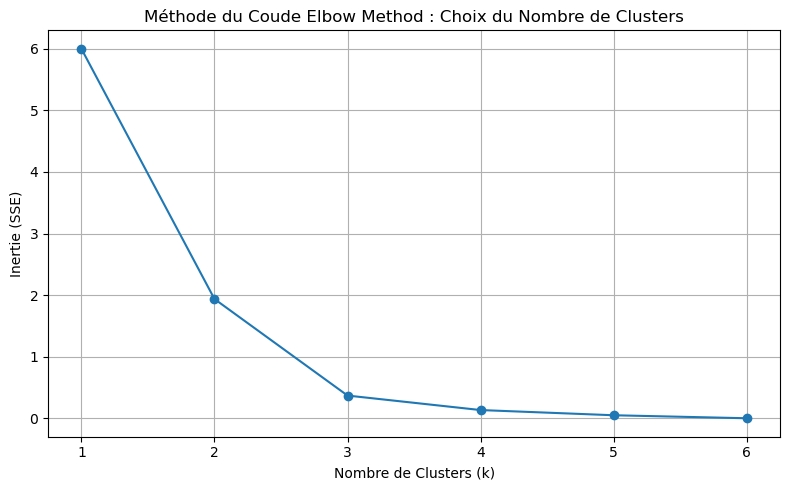

In [34]:

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertias, marker='o')
plt.title("M√©thode du Coude Elbow Method : Choix du Nombre de Clusters")
plt.xlabel("Nombre de Clusters (k)")
plt.ylabel("Inertie (SSE)")
plt.xticks(K_range)
plt.grid(True)
plt.tight_layout()
plt.show()


## Interpr√©tation : 
D‚Äôapr√®s la m√©thode elbow, 3 clusters est le nombre optimal pour regrouper tes cat√©gories de produits selon leur taux de casse, car c‚Äôest √† ce niveau que la r√©duction de l‚Äôinertie commence √† devenir marginale.

In [36]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_casse_cat[['taux_casse']])


kmeans = KMeans(n_clusters=3, random_state=0)
df_casse_cat['cluster'] = kmeans.fit_predict(X_scaled)

C:\Users\alaed\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


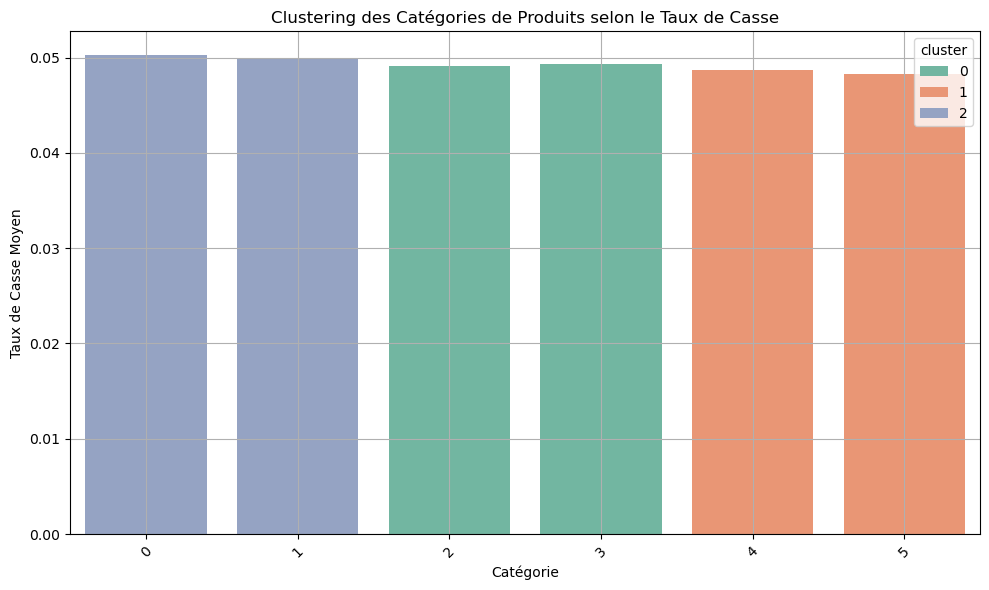

In [37]:
plt.figure(figsize=(10, 6))
df_casse_cat_sorted = df_casse_cat.sort_values(by='taux_casse', ascending=False)

sns.barplot(data=df_casse_cat_sorted, x='Categorie', y='taux_casse', hue='cluster', dodge=False, palette='Set2')

plt.title("Clustering des Cat√©gories de Produits selon le Taux de Casse")
plt.xlabel("Cat√©gorie")
plt.ylabel("Taux de Casse Moyen")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


#### Interpr√©tation : 

- Cluster 2 : pr√©sente un taux de casse moyen de 0.05, correspondant √† des produits avec un risque mod√©r√© de casse.

- Cluster 1 : regroupe les produits avec le taux de casse le plus faible 0.046, ce sont les cat√©gories les plus stables.

- Cluster 0 : comprend les cat√©gories ayant un taux de casse moyen de 0.049. Ces produits n√©cessitent une attention particuli√®re pour r√©duire les pertes.





In [39]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_casse_entrepot[['taux_casse']])
inertias = []
K_range = range(1, len(X_scaled) + 1)


for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

C:\Users\alaed\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\alaed\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\alaed\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\alaed\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

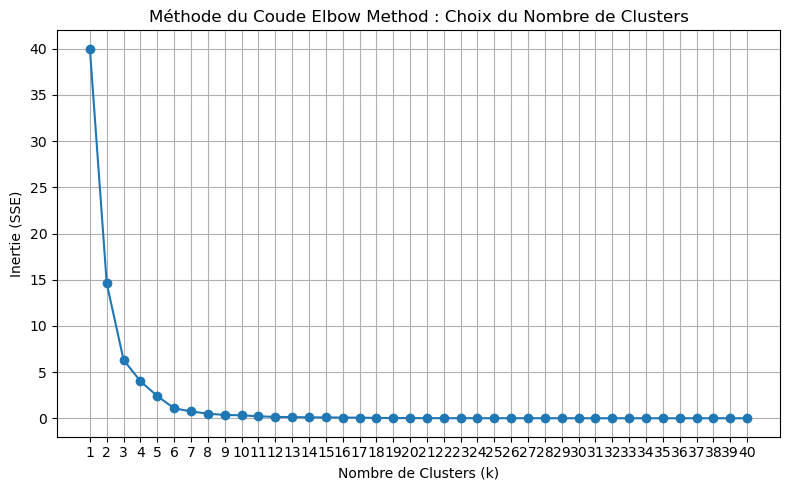

In [40]:
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertias, marker='o')
plt.title("M√©thode du Coude Elbow Method : Choix du Nombre de Clusters")
plt.xlabel("Nombre de Clusters (k)")
plt.ylabel("Inertie (SSE)")
plt.xticks(K_range)
plt.grid(True)
plt.tight_layout()
plt.show()

## Interpr√©tation : 
D‚Äôapr√®s la m√©thode elbow, 5 clusters est le nombre optimal pour regrouper tes cat√©gories de produits selon leur taux de casse, car c‚Äôest √† ce niveau que la r√©duction de l‚Äôinertie commence √† devenir marginale.

In [42]:
scaler = StandardScaler()
X_entrepot_scaled = scaler.fit_transform(df_casse_entrepot[['taux_casse']])
kmeans = KMeans(n_clusters=5, random_state=0)
df_casse_entrepot['cluster'] = kmeans.fit_predict(X_entrepot_scaled)




C:\Users\alaed\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


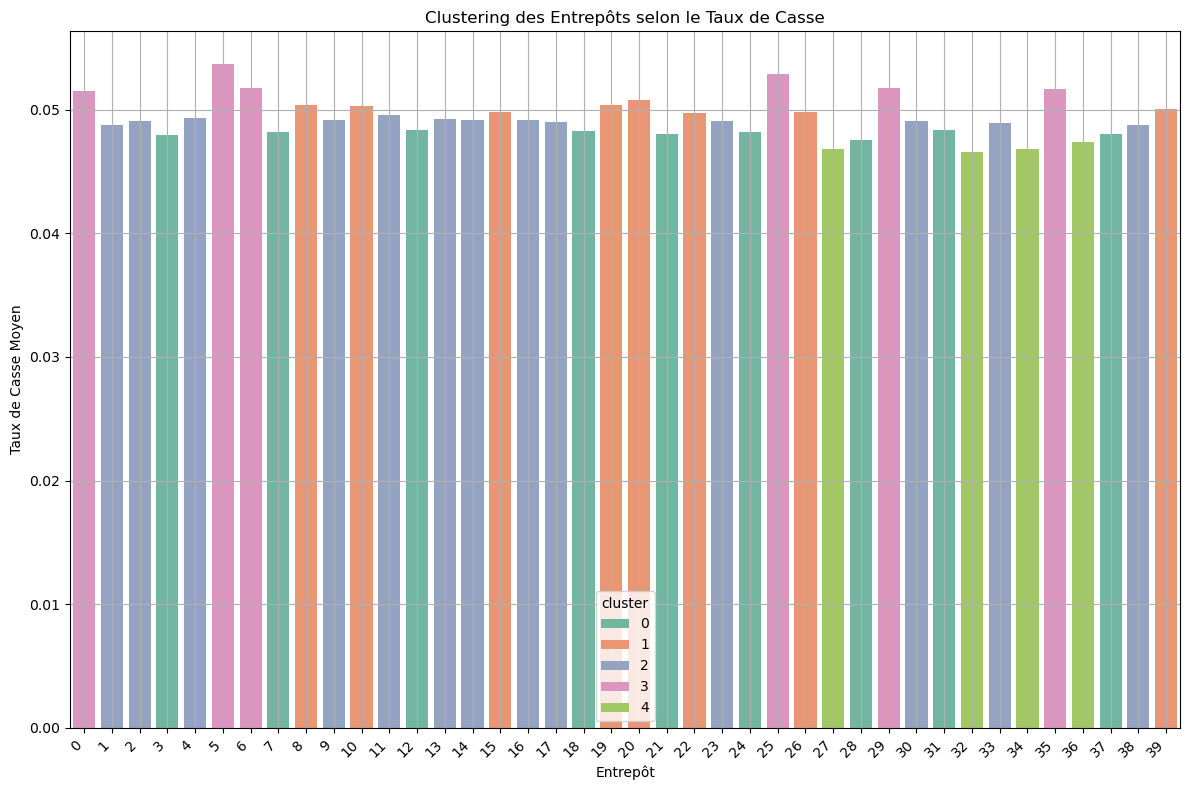

In [43]:
plt.figure(figsize=(12, 8))
df_casse_entrepot_sorted = df_casse_entrepot.sort_values(by='taux_casse', ascending=False)

sns.barplot(data=df_casse_entrepot_sorted, x='warehousename', y='taux_casse', hue='cluster', dodge=False, palette='Set2')

plt.title("Clustering des Entrep√¥ts selon le Taux de Casse")
plt.xlabel("Entrep√¥t")
plt.ylabel("Taux de Casse Moyen")
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()




#### Interpr√©tation : 

Cluster 0 : Regroupe les entrep√¥ts ayant le taux de casse moyen le plus √©lev√© (‚âà 0.056).Cela indique une zone √† risque n√©cessitant des actions correctives urgentes, telles que l‚Äôam√©lioration des conditions de stockage ou la formation du personnel.

Cluster 1 : Correspond aux entrep√¥ts les plus performants, avec un taux de casse le plus faible (‚âà 0.044). Ils repr√©sentent une r√©f√©rence en termes de bonnes pratiques logistiques, et peuvent servir de mod√®le pour les autres groupes.

Cluster 2 : Comprend des entrep√¥ts avec un taux de casse moyen (‚âà 0.052). Ils sont en situation stable, mais pourraient b√©n√©ficier d‚Äôanalyses suppl√©mentaires pour √©viter une d√©gradation future.

Cluster 3 : Taux de casse l√©g√®rement sup√©rieur √† la moyenne (‚âà 0.053). Ces entrep√¥ts pourraient faire l‚Äôobjet de diagnostics cibl√©s pour comprendre l‚Äôorigine des pertes.

Cluster 4 : Taux de casse mod√©r√© (‚âà 0.050), l√©g√®rement meilleur que la moyenne. Ces entrep√¥ts sont globalement ma√Ætris√©s, mais peuvent encore optimiser certains aspects pour atteindre les standards du cluster 1.





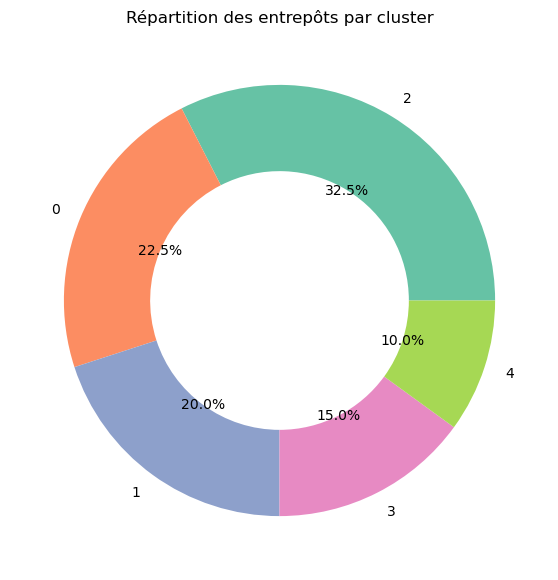

In [45]:
cluster_counts = df_casse_entrepot['cluster'].value_counts()

plt.figure(figsize=(7, 7))
plt.pie(cluster_counts, labels=cluster_counts.index, autopct='%1.1f%%',
        colors=sns.color_palette("Set2"), wedgeprops=dict(width=0.4))

plt.title("R√©partition des entrep√¥ts par cluster")
plt.show()


 ## Mod√©le AgglomerativeClustering

#### Avantages :
- Pas besoin de d√©finir k au d√©part.
- G√®re bien les clusters de formes vari√©es.
- Hi√©rarchie des groupes.

#### Inconv√©nients :
- Plus lent sur gros datasets.
- Peut √™tre plus difficile √† param√©trer (choix du linkage : single, complete, average‚Ä¶)

In [49]:
from sklearn.cluster import AgglomerativeClustering

X_scaled = scaler.fit_transform(df_casse_cat[['taux_casse']])

agglo_cat = AgglomerativeClustering(n_clusters=3)
df_casse_cat['cluster'] = agglo_cat.fit_predict(X_scaled)





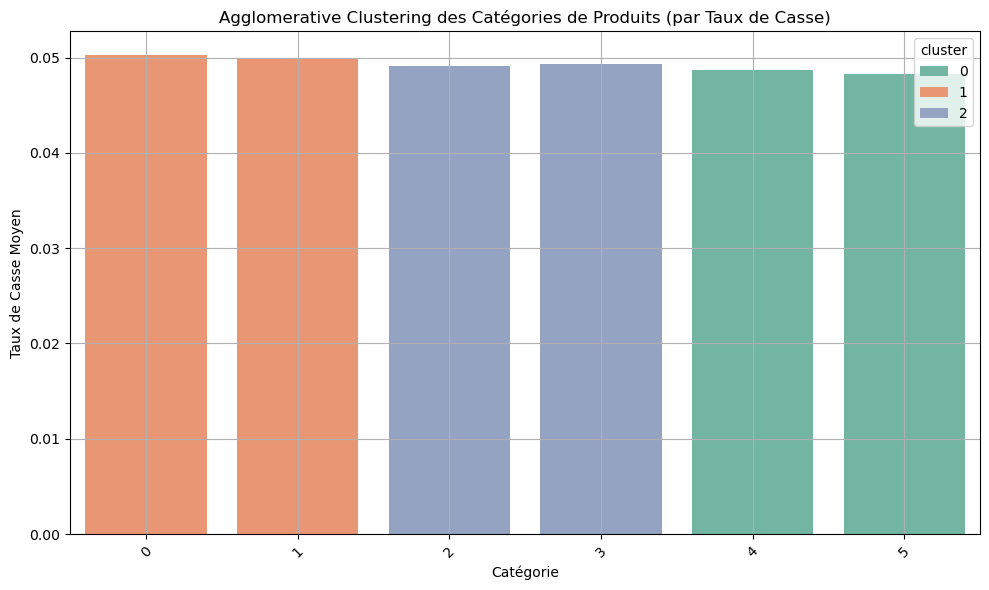

In [50]:
plt.figure(figsize=(10, 6))
df_casse_cat_sorted = df_casse_cat.sort_values(by='taux_casse', ascending=False)
sns.barplot(data=df_casse_cat_sorted, x='Categorie', y='taux_casse', hue='cluster', dodge=False, palette='Set2')
plt.title("Agglomerative Clustering des Cat√©gories de Produits (par Taux de Casse)")
plt.xlabel("Cat√©gorie")
plt.ylabel("Taux de Casse Moyen")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


### Interpr√©tation :
- Cluster 0 : pr√©sente un taux de casse moyen 0.049, correspondant √† des produits avec un risque mod√©r√© de casse.

- Cluster 1 : regroupe les produits avec le taux de casse le plus faible 0.045, ce sont les cat√©gories les plus stables.

- Cluster 2 : comprend les cat√©gories ayant un taux de casse moyen le plus √©lev√© 0.053. Ces produits n√©cessitent une attention particuli√®re pour r√©duire les pertes.

In [52]:
scaler = StandardScaler()
X_entrepot_scaled = scaler.fit_transform(df_casse_entrepot[['taux_casse']])

agglo_entrepot = AgglomerativeClustering(n_clusters=5)
df_casse_entrepot['cluster'] = agglo_entrepot.fit_predict(X_entrepot_scaled)


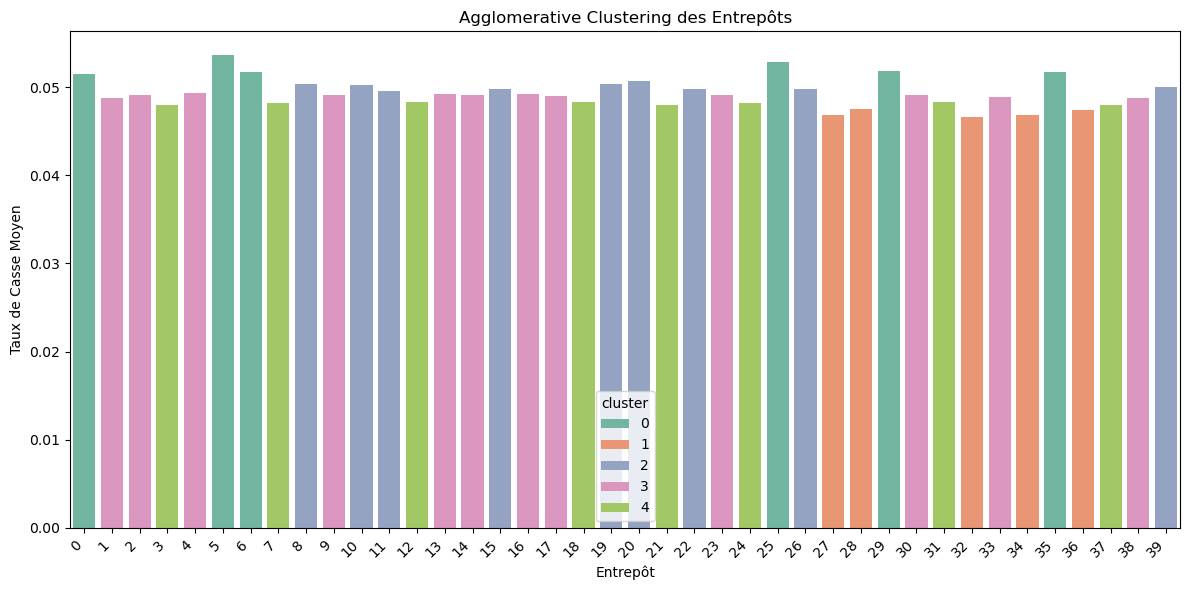

In [53]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df_casse_entrepot.sort_values(by='taux_casse'), x='warehousename', y='taux_casse', hue='cluster', dodge=False, palette='Set2')
plt.title("Agglomerative Clustering des Entrep√¥ts")
plt.xlabel("Entrep√¥t")
plt.ylabel("Taux de Casse Moyen")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

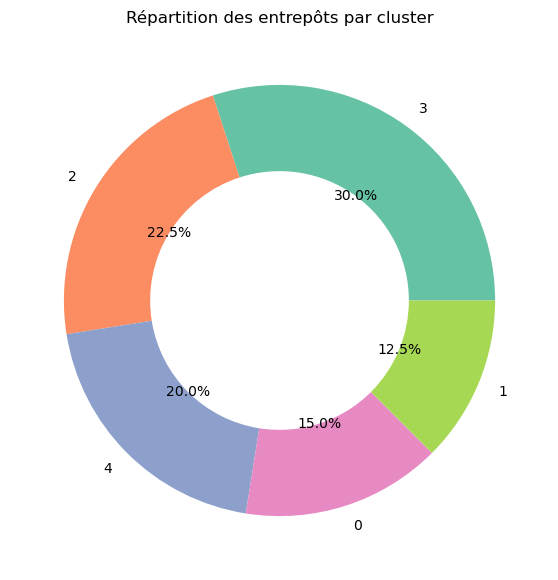

In [54]:
cluster_counts = df_casse_entrepot['cluster'].value_counts()

plt.figure(figsize=(7, 7))
plt.pie(cluster_counts, labels=cluster_counts.index, autopct='%1.1f%%',
        colors=sns.color_palette("Set2"), wedgeprops=dict(width=0.4))

plt.title("R√©partition des entrep√¥ts par cluster")
plt.show()


## Interpr√©tation :
- Les deux mod√®les donnent des r√©sultats coh√©rents.

## Supervis√© ‚Äì Classification


### Pr√©dire si un produit est "√† risque"


 Approche pr√©dictive : on cherche √† pr√©voir une variable cible √† partir de donn√©es historiques.

- Il g√®re bien les **donn√©es h√©t√©rog√®nes** et les relations non lin√©aires.
- Il est robuste au **bruit** et aux valeurs aberrantes.
- Il permet une bonne **interpr√©tabilit√©** via l‚Äôimportance des variables.
- Il √©vite le sur-apprentissage gr√¢ce √† l‚Äô**agr√©gation de multiples arbres**

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, RocCurveDisplay

In [61]:

df_encoded['is_dormant'] = (df_encoded['Stock_Sortant'] == 0).astype(int)
df_encoded['taux_casse'] = df_encoded['Produits_Endommages'] / df_encoded['Stock_Initial']
df_encoded['is_risque'] = (
    (df_encoded['taux_casse'] > 0.1) |
    (df_encoded['is_dormant'] == 1) |
    (df_encoded['Temperature'].isin([1, 2])) 
).astype(int)


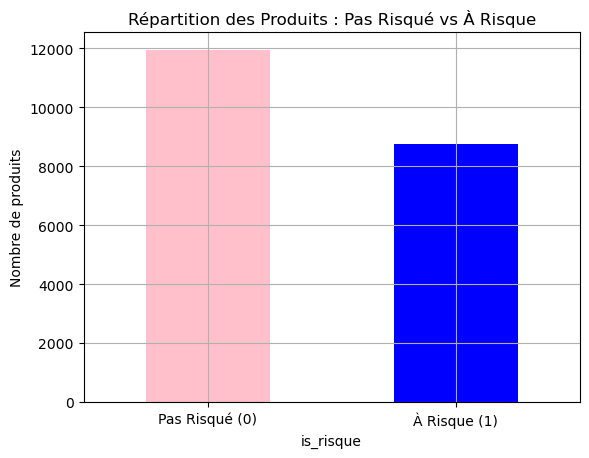

In [62]:
df_encoded['is_risque'].value_counts().plot(kind='bar', color=['pink', 'blue'])
plt.xticks([0,1], ['Pas Risqu√© (0)', '√Ä Risque (1)'], rotation=0)
plt.title("R√©partition des Produits : Pas Risqu√© vs √Ä Risque")
plt.ylabel("Nombre de produits")
plt.grid(True)
plt.show()


### Interpr√©tation : 
Le graphique montre un d√©s√©quilibre entre les produits "pas risqu√©s(0)" majoritaires et "√† risque(1)" minoritaires, ce qui justifie un r√©√©quilibrage des donn√©es

In [64]:
df_majority = df_encoded[df_encoded['is_risque'] == 0]
df_minority = df_encoded[df_encoded['is_risque'] == 1]

df_minority_upsampled = df_minority.sample(n=len(df_majority), replace=True, random_state=42)
df_balanced = pd.concat([df_majority, df_minority_upsampled])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)


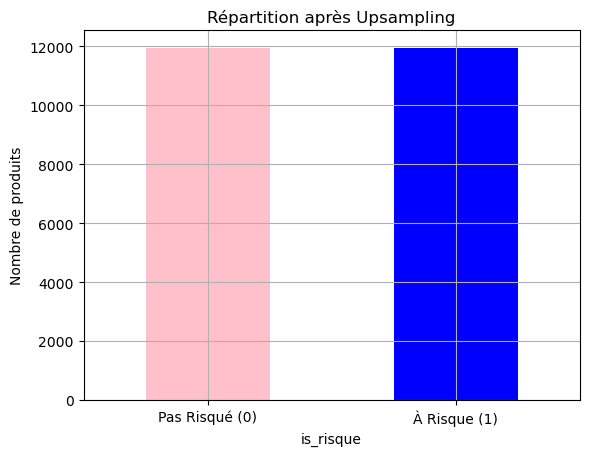

In [65]:
df_balanced['is_risque'].value_counts().plot(kind='bar', color=['pink', 'blue'])
plt.xticks([0,1], ['Pas Risqu√© (0)', '√Ä Risque (1)'], rotation=0)
plt.title("R√©partition apr√®s Upsampling")
plt.ylabel("Nombre de produits")
plt.grid(True)
plt.show()


### Interpr√©tation :
Le graphique montre que la r√©partition entre les produits "pas risqu√©s(0)" et "√† risque(1)" est d√©sormais √©quilibr√©e apr√®s l‚Äôupsampling.

## Mod√®le RandomForest

#### Avantages :
- Robuste au surapprentissage.
- G√®re bien les variables cat√©gorielles.
- Permet d‚Äôinterpr√©ter les r√©sultats via feature importance.


#### Inconv√©nients :
- Moins performant si les classes sont tr√®s d√©s√©quilibr√©es.

In [70]:
features = ['Temperature', 'Stock_Initial', 'Stock_Entrant', 'Stock_Sortant']
X = df_balanced[features].fillna(0)
y = df_balanced['is_risque']

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf = RandomForestClassifier(n_estimators=200,         
    max_depth=10,              
    min_samples_split=5,      
    min_samples_leaf=2,       
    max_features='sqrt',       
    bootstrap=True,
    random_state=42,
    class_weight='balanced')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      2359
           1       0.95      0.93      0.94      2417

    accuracy                           0.94      4776
   macro avg       0.94      0.94      0.94      4776
weighted avg       0.94      0.94      0.94      4776



#### Interpr√©tation :
Le mod√®le RandomForest obtient une accuracy de 94% , ce qui signifie qu‚Äôil pr√©dit correctement si un produit est √† risque ou non.

**Analyse par classe :**

- Classe 0 (pas risqu√©) : pr√©cision = 0.93, rappel = 0.96 : bon √† tr√®s bon.

- Classe 1 (√† risque) : pr√©cision = 0.96, rappel = 0.92 : bonne capacit√© √† d√©tecter les produits √† risque.

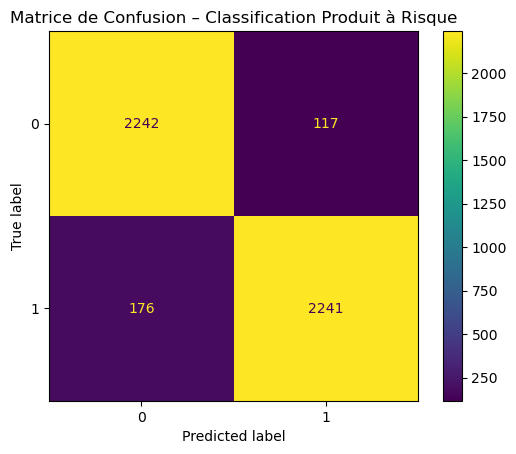

In [73]:
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)
plt.title("Matrice de Confusion ‚Äì Classification Produit √† Risque")
plt.show()

#### Interpr√©tation :   
Le mod√®le  : 

Vrais n√©gatifs (TN) : 2306

Faux positifs (FP) : 98

Faux n√©gatifs (FN) : 180

Vrais positifs (TP) : 2192

 ## Mod√®le Logistic Regression


#### Avantages :
- Facile √† interpr√©ter.
- Rapide √† entra√Æner.


#### Inconv√©nients :
- Limit√© aux relations lin√©aires.
- Moins performant si les classes sont tr√®s d√©s√©quilibr√©es.

In [78]:

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print("Rapport de classification - LogisticRegression")
print(classification_report(y_test, y_pred))

Rapport de classification - LogisticRegression
              precision    recall  f1-score   support

           0       0.91      0.94      0.93      2359
           1       0.94      0.91      0.93      2417

    accuracy                           0.93      4776
   macro avg       0.93      0.93      0.93      4776
weighted avg       0.93      0.93      0.93      4776



#### Interpr√©tation :
Le mod√®le Logistic Regression obtient une accuracy de 93% , ce qui signifie qu‚Äôil pr√©dit correctement si un produit est √† risque ou non dans 93% des cas.

**Analyse par classe :**

- Classe 0 (pas risqu√©) : pr√©cision = 0.92, rappel = 0.95 : bon √† tr√®s bon.

- Classe 1 (√† risque) : pr√©cision = 0.95, rappel = 0.91 : bonne capacit√© √† d√©tecter les produits √† risque.

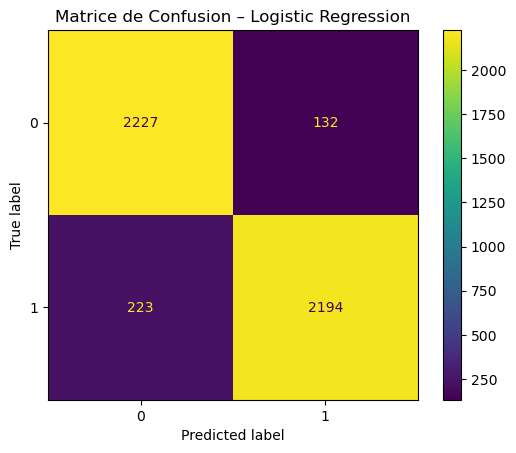

In [80]:
ConfusionMatrixDisplay.from_estimator(logreg, X_test, y_test)
plt.title("Matrice de Confusion ‚Äì Logistic Regression")
plt.show()

Interpr√©tation :
Le mod√®le  :

 vrais n√©gatifs (TN) :  2265

 vrais positifs (TP) :  2194

 faux positifs (FP) :  124

 faux n√©gatifs (FN) :  193

## Mod√©le SVM 

#### Avantages :
- Efficace pour des donn√©es non lin√©aires avec kernel RBF.
- Bonne performance sur petits datasets complexes.

#### Inconv√©nients :
- Sensible au tuning des hyperparam√®tres.
- Lent si beaucoup d‚Äôexemples.

In [85]:
model = SVC(kernel='rbf', probability=True)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


print("üìã Rapport de classification (SVM):\n")
print(classification_report(y_test, y_pred))





üìã Rapport de classification (SVM):

              precision    recall  f1-score   support

           0       0.56      0.77      0.65      2359
           1       0.65      0.42      0.51      2417

    accuracy                           0.59      4776
   macro avg       0.61      0.59      0.58      4776
weighted avg       0.61      0.59      0.58      4776



#### Interpr√©tation :
Le mod√®le SVM obtient une accuracy de 59% , ce qui signifie qu‚Äôil pr√©dit correctement si un produit est √† risque ou non dans 59% des cas.

**Analyse par classe :**

- Classe 0 (Pas risqu√©) : pr√©cision = 0.56, rappel = 0.77 : plut√¥t correct mais am√©liorable.

- Classe 1 (√Ä risque) : pr√©cision = 0.65, rappel = 0.42 : les produits √† risque sont moins bien d√©tect√©s

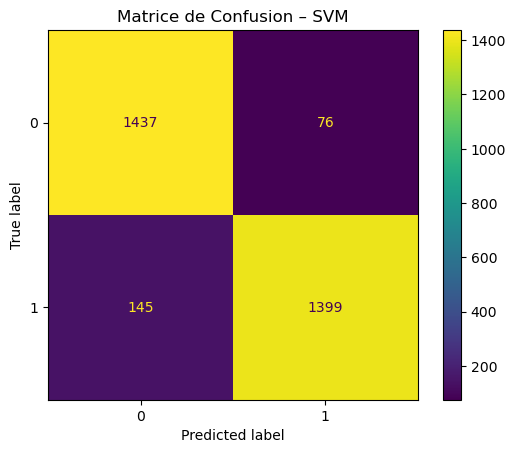

In [129]:
ConfusionMatrixDisplay.from_estimator(logreg, X_test, y_test)
plt.title("Matrice de Confusion ‚Äì SVM")
plt.show()

Interpr√©tation :
Le mod√®le  :

- 1437 vrais n√©gatifs, 1399 vrais positifs
- 145 faux positifs ,76 faux n√©gatifs

## Interpr√©tation :
Random Forest offre la meilleure pr√©cision puisque il a donn√©e la meilleure accurancy 94% .

## R√©gression supervis√©e

### Pr√©dire la quantit√© de stock futur

 Approche pr√©dictive : on cherche √† pr√©voir une variable cible √† partir de donn√©es historiques.

In [140]:
features = ['Stock_Entrant', 'Stock_Sortant', 'Produits_Endommages','capacity']
target = 'Stock_Final'



In [142]:
X = df_encoded[features].fillna(0)
y =  df_encoded[target]

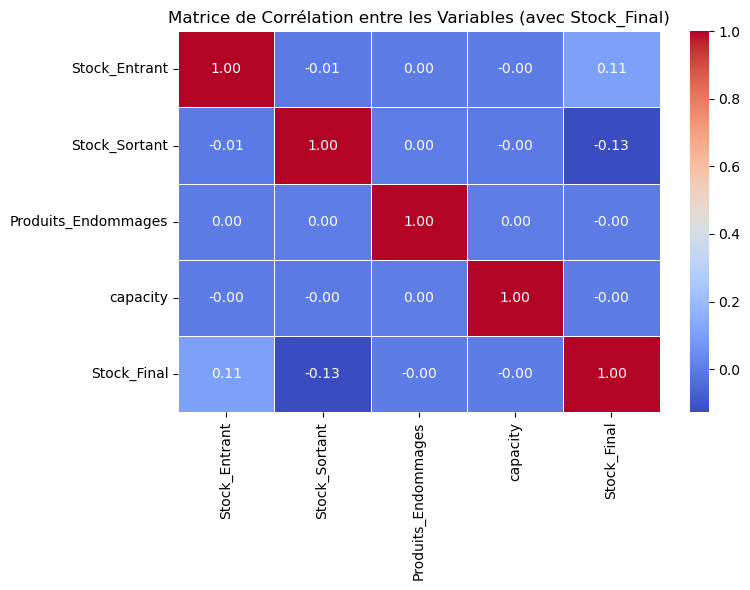

In [150]:


#  Pr√©pare ton DataFrame avec X (features) et y (target)
data_with_target = X.copy()
data_with_target['Stock_Final'] = y  

#  Calcul de la matrice de corr√©lation avec la target incluse
corr_matrix = data_with_target.corr()

#  Visualisation
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Matrice de Corr√©lation entre les Variables (avec Stock_Final)")
plt.tight_layout()
plt.show()



In [152]:

# 2Ô∏è‚É£. Fonction de Data Augmentation (ajout de bruit gaussien)
def augment_data(X, y, n_times=5, noise_level=0.05):
    X_aug = X.copy()
    y_aug = y.copy()
    
    for _ in range(n_times):
        X_noise = X + np.random.normal(0, noise_level * X.std(), X.shape)
        X_aug = pd.concat([X_aug, X_noise], axis=0)
        y_aug = pd.concat([y_aug, y], axis=0)  # Garder la m√™me cible (pas de bruit sur y)
    
    return X_aug.reset_index(drop=True), y_aug.reset_index(drop=True)

# 3Ô∏è‚É£. Appliquer l‚Äôaugmentation (par exemple, multiplier les donn√©es par 5)
X_augmented, y_augmented = augment_data(X, y, n_times=5, noise_level=0.05)

print(f"Taille des donn√©es avant augmentation : {X.shape[0]}")
print(f"Taille des donn√©es apr√®s augmentation : {X_augmented.shape[0]}")


Taille des donn√©es avant augmentation : 20689
Taille des donn√©es apr√®s augmentation : 124134


In [159]:
from sklearn.model_selection import train_test_split

## Mod√©le XGBRegressor

#### Avantages :
- Tr√®s performant, surtout sur des donn√©es complexes.
- Prend en compte les interactions entre features.

#### Inconv√©nient :
- Plus complexe √† interpr√©ter que les mod√®les simples

In [164]:

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)



In [166]:


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

from xgboost import XGBRegressor
model = XGBRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)



In [167]:
from sklearn.metrics import mean_squared_error, r2_score
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"üìâ RMSE : {rmse:.2f}")
print(f"üìä R¬≤ Score : {r2:.2f}")

üìâ RMSE : 0.20
üìä R¬≤ Score : 0.84


#### Interpr√©tation : 
##### RMSE : 
Faible erreur moyenne

Le mod√®le se trompe en moyenne de 0.19 unit√©s de stock par pr√©diction
le mod√®le est tr√®s pr√©cis puisque une valeur plus proche de 0 indique une meilleure performance surtout les stocks sont en milliers.

##### R¬≤ :
Le mod√®le explique 85% des variations dans les stocks finaux, Cela veut dire que toutes les fluctuations du Stock_Final sont tr√®s bien capt√©es par les variables (Stock_Initial, Entrant, Sortant...).

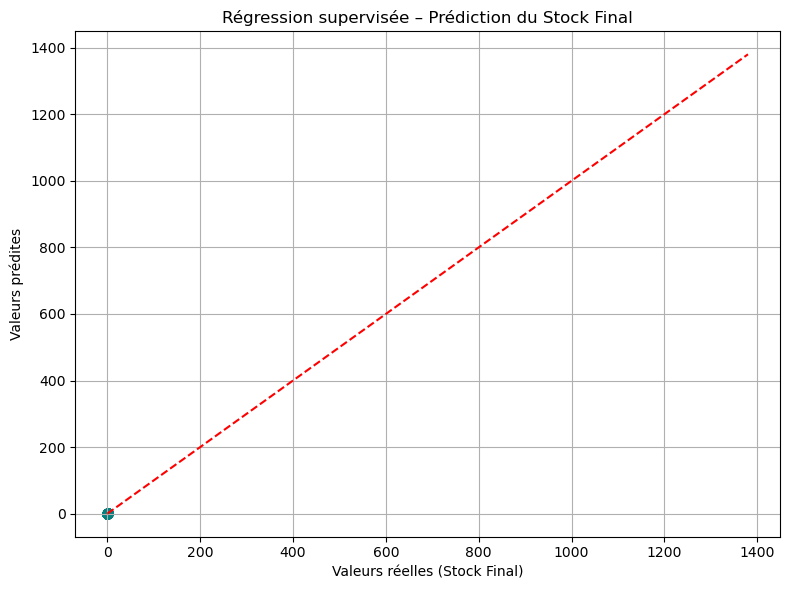

In [171]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.4, color='teal')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Valeurs r√©elles (Stock Final)")
plt.ylabel("Valeurs pr√©dites")
plt.title("R√©gression supervis√©e ‚Äì Pr√©diction du Stock Final")
plt.grid(True)
plt.tight_layout()
plt.show()


#### Interpr√©tation : 
Le mod√®le de r√©gression utilis√©  montre une tr√®s bonne capacit√© pr√©dictive pour estimer le stock final.

## Mod√©le RandomForestRegresso

#### Avantages :
- Facile √† utiliser.
- Bonne gestion des non-lin√©arit√©s.
- Donne l‚Äôimportance des variables.

#### Inconv√©nients :
- Moins pr√©cis que XGBoost si besoin d‚Äôune tr√®s haute performance.
- Peut devenir lent si dataset √©norme.

In [177]:
from sklearn.ensemble import RandomForestRegressor

In [179]:

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)



In [181]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)


In [182]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"üìâ RMSE : {rmse:.2f}")
print(f"üìä R¬≤ Score : {r2:.2f}")


üìâ RMSE : 0.20
üìä R¬≤ Score : 0.84


#### Interpr√©tation : 
##### RMSE : 
Faible erreur moyenne

Le mod√®le se trompe en moyenne de 0.20 unit√©s de stock par pr√©diction
le mod√®le est tr√®s pr√©cis puisque une valeur plus proche de 0 indique une meilleure performance surtout les stocks sont en milliers.

##### R¬≤ :
Le mod√®le explique 84% des variations dans les stocks finaux, Cela veut dire que toutes les fluctuations du Stock_Final sont tr√®s bien capt√©es par les variables (Stock_Initial, Entrant, Sortant...).

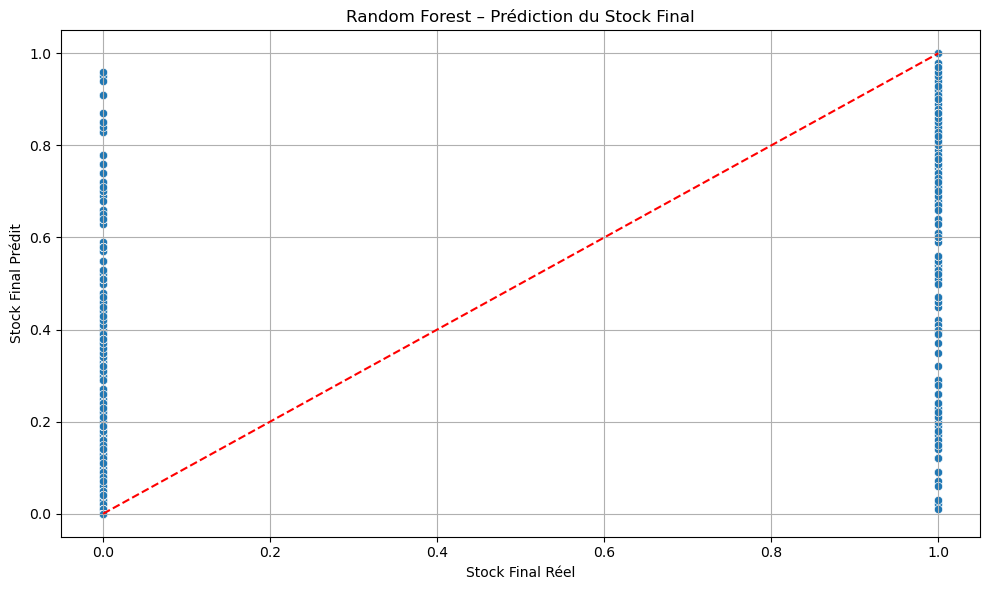

In [184]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Stock Final R√©el")
plt.ylabel("Stock Final Pr√©dit")
plt.title("Random Forest ‚Äì Pr√©diction du Stock Final")
plt.grid(True)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.tight_layout()
plt.show()


### Interpr√©tation :
Le graphique montre une forte concentration de points aux extr√™mes (0 ou 1)

## Interpr√©tation :
XGBoost Regressor est clairement le meilleur mod√®le pour pr√©dire le stock final

## System de recomandation
Quels produits doivent √™tre r√©approvisionn√©s en priorit√©, en se basant sur :

- taux de casse

- niveau de stock

- volume de vente

- sensibilit√© 

In [214]:

df_merged_cleaned['taux_casse'] = df_merged_cleaned['Produits_Endommages'] / df_merged_cleaned['Stock_Initial']


recommandations = df_merged_cleaned[
    (df_merged_cleaned['Stock_Final'] < 50) & 
    ((df_merged_cleaned['Stock_Sortant'] > 100) | (df_merged_cleaned['taux_casse'] > 0.05))
]


recommandations = recommandations.sort_values(by='taux_casse', ascending=False)


recommandations[['Product_Name', 'Stock_Final', 'Stock_Sortant', 'taux_casse']]


Product_Name  Stock_Final  \
9799        Princess Eau de Parfum with Vanilla & Ginger            0   
17781  C.E.O. Vitamin C Brightening Rich Hydration Mo...           19   
1704          BADgal BANG! Volumizing Waterproof Mascara           30   
3603        Curl Wow COCO-MOTION Lubricating Conditioner            0   
6305   KP Bump Eraser Body Scrub with 10% AHA ÔøΩÔøΩÔøΩ Bod...            0   
...                                                  ...          ...   
13610         Afterglow Sensual Shine Hydrating Lipstick           46   
1951             Crushed Lip Color Moisturizing Lipstick            0   
2521                       Good Girl Blush Eau de Parfum            0   
1655   Goof Proof Waterproof Easy Shape & Fill Eyebro...           14   
19701             Spike Valentino Buttery Matte Lipstick           28   

       Stock_Sortant  taux_casse  
9799             474    0.237864  
17781             57    0.235577  
1704             432    0.230392  
3603             308    0.227053  
6305             540    0.223881  
...              ...         ...  
13610            257    0.000000  
1951             242    0.000000  
2521             449    0.000000  
1655             592    0.000000  
19701            416    0.000000  

[734 rows x 4 columns]

## D√©ploiement avec Flask

 - Entra√Æner le mod√®le et l‚Äôenregistrer

In [192]:
import pickle

# Exemple : random forest entra√Æn√©
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Sauvegarder le mod√®le
with open("model.pkl", "wb") as f:
    pickle.dump(model, f)




- Cr√©er un fichier : 

## S√©rie temporelle

### Pr√©dire quel entrep√¥t va vendre la plus grande quantit√© de produits dans le temps.

 Approche pr√©dictive : on cherche √† pr√©voir une variable cible √† partir de donn√©es historiques.

In [125]:
pip install pandas matplotlib statsmodels


Note: you may need to restart the kernel to use updated packages.



üì¶ Analyse de l'entrep√¥t : E1


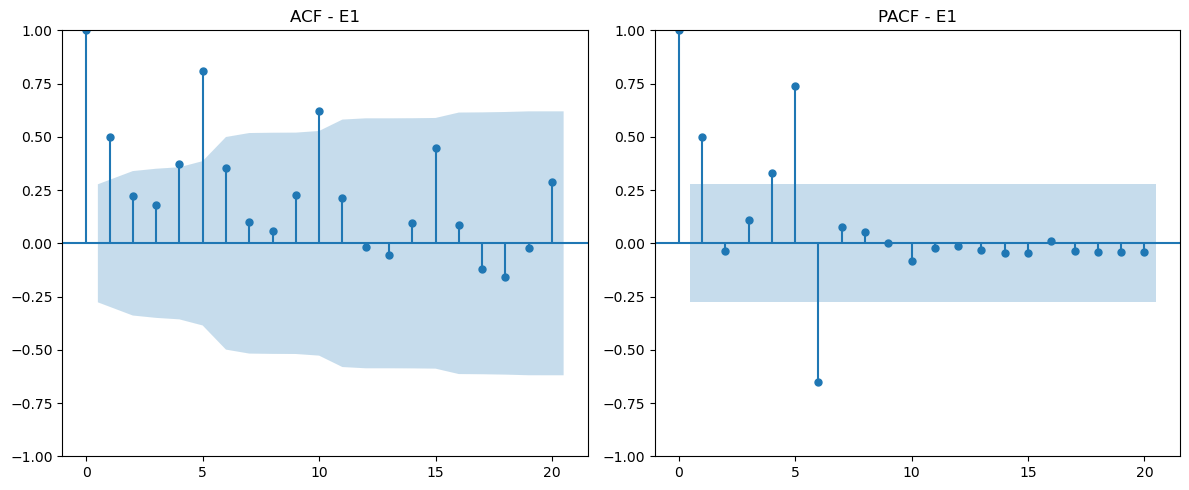

C:\Users\alaed\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alaed\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



üì¶ Analyse de l'entrep√¥t : E2


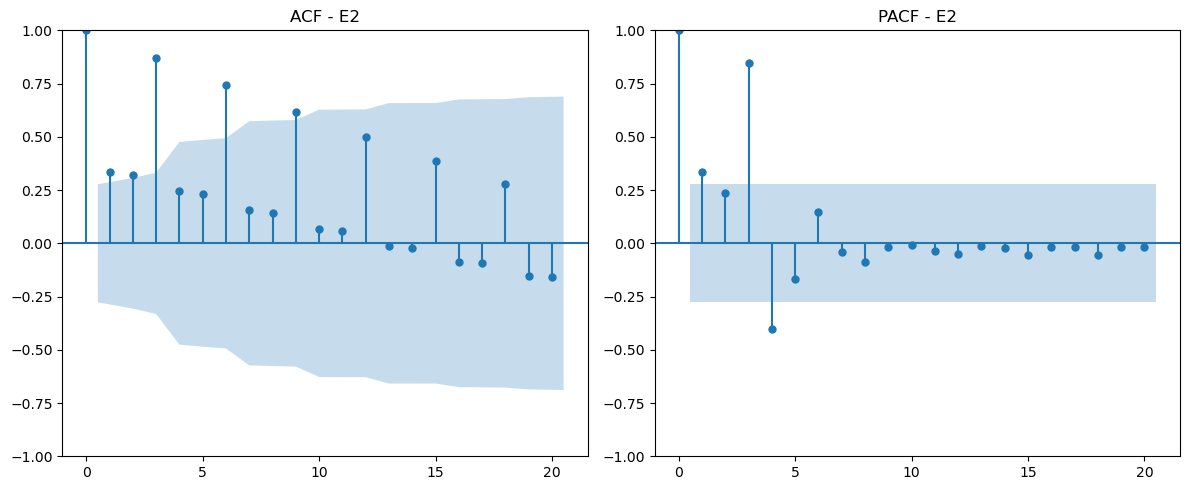

C:\Users\alaed\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alaed\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                          Quantite   No. Observations:                   50
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood                -130.325
Date:                           Tue, 29 Apr 2025   AIC                            270.650
Time:                                   22:08:56   BIC                            278.133
Sample:                               02-20-2023   HQIC                           273.168
                                    - 04-10-2023                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4604      0.575     -0.801      0.423      -1.588       0.667
ma.L1         -1.0000   9028.100     -0.000

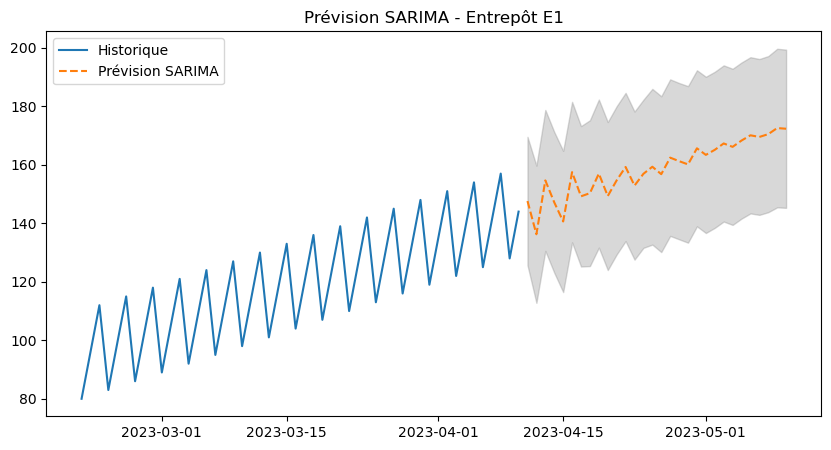

In [126]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np


# 1. Simuler des donn√©es 

data = pd.DataFrame({
    'Date': pd.date_range(start='2023-01-01', periods=100, freq='D'),
    'Entrepot': ['E1'] * 50 + ['E2'] * 50,
    'Quantite': [100 + i + (i % 5)*10 for i in range(50)] + [80 + i + (i % 3)*15 for i in range(50)]
})


# 2. Agr√©ger par entrep√¥t et par jour

df = data.groupby(['Date', 'Entrepot'])['Quantite'].sum().reset_index()


# 3. Boucle sur chaque entrep√¥t

forecast_horizon = 15  # jours √† pr√©dire
results = {}

for entrepot in df['Entrepot'].unique():
    print(f"\nüì¶ Analyse de l'entrep√¥t : {entrepot}")
    df_ent = df[df['Entrepot'] == entrepot].copy()
    df_ent.set_index('Date', inplace=True)
    ts = df_ent['Quantite']
    
   
    # 4. ACF et PACF
    
    plt.figure(figsize=(12, 5))
    plt.subplot(121)
    plot_acf(ts, ax=plt.gca(), lags=20)
    plt.title(f"ACF - {entrepot}")
    
    plt.subplot(122)
    plot_pacf(ts, ax=plt.gca(), lags=20, method="ywm")
    plt.title(f"PACF - {entrepot}")
    plt.tight_layout()
    plt.show()
    
    
    # 5. Split pour entra√Ænement/test
   
    train = ts[:-forecast_horizon]
    test = ts[-forecast_horizon:]

   
    # 6. Appliquer SARIMA (choix exemple : p=1, d=1, q=1)
    
   
    model = SARIMAX(ts, 
                order=(1,1,1),               # ARIMA
                seasonal_order=(1,1,1,7),    # SARIMA, s=7 pour hebdo
                enforce_stationarity=False, 
                enforce_invertibility=False)

results = model.fit()

print(results.summary())


# 5. Pr√©vision future

forecast = results.get_forecast(steps=30)
predicted_mean = forecast.predicted_mean
conf_int = forecast.conf_int()


# 6. Visualisation

plt.figure(figsize=(10, 5))
plt.plot(ts, label='Historique')
plt.plot(predicted_mean, label='Pr√©vision SARIMA', linestyle='--')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.3)
plt.legend()
plt.title("Pr√©vision SARIMA - Entrep√¥t E1")
plt.show()

In [127]:
model = ARIMA(ts, order=(1, 1, 1))  # (p,d,q)
results = model.fit()

print(results.summary())

# -------------------------
# 5. Pr√©vision
# -------------------------
forecast = results.get_forecast(steps=30)
predicted_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# -------------------------
# 6. Visualisation
# -------------------------
plt.figure(figsize=(10, 5))
plt.plot(ts, label='Historique')
plt.plot(predicted_mean, label='Pr√©vision', linestyle='--')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.3)
plt.legend()
plt.title("Pr√©vision avec ARIMA - Entrep√¥t E1")
plt.show()

NameError: name 'ARIMA' is not defined

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings("ignore")

# --------------------------
# 1. Pr√©paration des donn√©es
# --------------------------
df = df_encoded.copy()

df['fulldate'] = pd.to_datetime(df['fulldate'], errors='coerce')
df = df.dropna(subset=['fulldate', 'Stock_Sortant', 'Product_Name'])

forecast_horizon = 15  # jours √† pr√©dire
results_by_product = {}

# --------------------------
# 2. Boucle sur chaque produit
# --------------------------
for produit in df['Product_Name'].unique():
    print(f"\nüß¥ Analyse du produit : {produit}")

    # Donn√©es du produit
    df_prod = df[df['Product_Name'] == produit][['fulldate', 'Stock_Sortant']]
    df_prod = df_prod.groupby('fulldate').sum().reset_index()
    df_prod = df_prod.set_index('fulldate').asfreq('D')
    ts = df_prod['Stock_Sortant'].fillna(method='ffill')

    if len(ts) < 30:
        print("‚õî Donn√©es insuffisantes pour le produit :", produit)
        continue

    # --------------------------
    # ACF / PACF
    # --------------------------
    ts_diff = ts.diff().dropna()
    if len(ts_diff) > 20:
        plt.figure(figsize=(12, 4))
        plt.subplot(121)
        plot_acf(ts_diff, ax=plt.gca(), lags=20)
        plt.title(f"ACF - Produit {produit}")

        plt.subplot(122)
        plot_pacf(ts_diff, ax=plt.gca(), lags=20, method="ywm")
        plt.title(f"PACF - Produit {produit}")
        plt.tight_layout()
        plt.show()

    # --------------------------
    # SARIMA
    # --------------------------
    try:
        model = SARIMAX(ts,
                        order=(1, 1, 1),
                        seasonal_order=(1, 1, 1, 7),
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        
        results = model.fit(disp=False)

        # Pr√©vision
        forecast = results.get_forecast(steps=forecast_horizon)
        predicted_mean = forecast.predicted_mean
        total_forecast = predicted_mean.sum()

        # Stocker
        results_by_product[produit] = total_forecast

        # Visualisation
        plt.figure(figsize=(10, 5))
        plt.plot(ts, label='Historique')
        plt.plot(predicted_mean, label='Pr√©vision SARIMA', linestyle='--')
        plt.fill_between(predicted_mean.index,
                         forecast.conf_int().iloc[:, 0],
                         forecast.conf_int().iloc[:, 1],
                         color='gray', alpha=0.3)
        plt.title(f"Pr√©vision SARIMA - Produit {produit}")
        plt.xlabel("Date")
        plt.ylabel("Stock Sortant")
        plt.legend()
        plt.grid()
        plt.show()

    except Exception as e:
        print(f"‚ùå Erreur pour le produit {produit} :", e)

# --------------------------
# 3. R√©sultats finaux
# --------------------------
df_resultats = pd.DataFrame.from_dict(results_by_product, orient='index', columns=['Pr√©vision_Totale'])
df_resultats = df_resultats.sort_values(by='Pr√©vision_Totale', ascending=False)

print("\nüèÜ Classement des produits selon la quantit√© pr√©vue √† sortir :")
print(df_resultats)

# --------------------------
# 4. Barplot comparatif
# --------------------------
plt.figure(figsize=(12, 5))
df_resultats.head(10).plot(kind='bar', legend=False)
plt.title("üß¥ Top 10 des produits les plus vendeurs (pr√©vision)")
plt.ylabel("Stock Sortant pr√©vu")
plt.xlabel("Produit")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# --------------------------
# 5. Export (optionnel)
# --------------------------
# df_resultats.to_excel("classement_produits_sarima.xlsx")
